# Assignment 5

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional notes:

* Please note that in this assignment, students are expected to work independently. As a result, no two solutions should look identical in terms of coding;
* You may import any libraries you need to complete the assignment. However, you must implement the model using TensorFlow (do not use PyTorch);
* Follow the same steps/idea as in Assignment 4; the difference here is that you extend a logistic model to more than two classes;
* <span style="color:chocolate"> Focus on the execution of the task rather than model performance </span> (this is how the TA will grade your work);
* Even though the prediction performance for your chosen outcome is low, it doesn't necessarily mean there is something wrong with your implementation. It could also be that the data is not supportive enough for your prediction task... again, focus on the learning opportunity and not the numbers you get;
* Your instructional team has extensive experience developing and running ML models. Often, we encounter situations where a model doesn't perform well on a predictive task. This can happen due to the nature of the data or the need for significant tweaking of variables to achieve good results;
* Do not spend significantly more time on this task than you did on Assignment 4, unless you wish to experiment and learn more.
---

``Objective``
* Perform multiclass classification using logistic regression. <span style="color:chocolate"> You will choose the outcome of interest. </span>

``Motivation``
* Chocolate is one of the most popular candies in the world. Each year, residents of the United States collectively eat more than 2.8 billions pounds (Source: Kaggle). However, not all chocolate bars are created equal! In this assignment, you will have the opportunity to delve into the world of chocolate by choosing your own machine learning task. 


``Data``

* The [Chocolate Bar dataset](https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings) contains expert ratings of 1,795 individual chocolate bars, along with information on their regional origin, percentage of cocoa, the variety of chocolate bean used and where the beans were grown (Source: Kaggle).

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters

# feel free to import other libraries as needed

import warnings
warnings.filterwarnings('ignore')

2025-02-16 23:55:06.024582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define functions

In [2]:
def read_data():
    ''''''
    # Read data
    df = pd.read_csv(
        "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv",
        sep=",",
        encoding='latin-1'
    )
    
    return df

In [3]:
def clean_data(df):
    ''''''
    # Set the output display to have one digit for decimal places and limit it to
    # printing 15 rows.
    pd.options.display.float_format = '{:.2f}'.format
    pd.options.display.max_rows = 15
    
    # Rename the columns.
    df.columns = [
        'maker', 'specific_origin', 'reference_number',
        'review_date', 'cocoa_percent', 'maker_location',
        'rating', 'bean_type', 'broad_origin'
    ]

    # df.dtypes

    # Replace empty/null values with "Blend"
    df['bean_type'] = df['bean_type'].fillna('Blend')

    # Cast bean_type to string to remove leading 'u'
    df['bean_type'] = df['bean_type'].astype(str)
    df['cocoa_percent'] = df['cocoa_percent'].str.strip('%')
    df['cocoa_percent'] = pd.to_numeric(df['cocoa_percent'])

    # Correct spelling mistakes, and replace city with country name
    df['maker_location'] = df['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

    # Adding this so that Holland and Netherlands map to the same country.
    df['maker_location'] = df['maker_location']\
    .str.replace('Holland', 'Netherlands')

    def cleanup_spelling_abbrev(text):
        replacements = [
            ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
            ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
            ['Mad,|Mad$', 'Madagascar, '],
            ['PNG', 'Papua New Guinea, '],
            ['Guat,|Guat$', 'Guatemala, '],
            ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
            ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
            ['Nic,|Nic$', 'Nicaragua, '],
            ['Cost Rica', 'Costa Rica'],
            ['Mex,|Mex$', 'Mexico, '],
            ['Jam,|Jam$', 'Jamaica, '],
            ['Haw,|Haw$', 'Hawaii, '],
            ['Gre,|Gre$', 'Grenada, '],
            ['Tri,|Tri$', 'Trinidad, '],
            ['C Am', 'Central America'],
            ['S America', 'South America'],
            [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
            [' Bali', ',Bali']
        ]
        for i, j in replacements:
            text = re.sub(i, j, text)
        return text

    df['specific_origin'] = df['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Cast specific_origin to string
    df['specific_origin'] = df['specific_origin'].astype(str)

    # Replace null-valued fields with the same value as for specific_origin
    df['broad_origin'] = df['broad_origin'].fillna(df['specific_origin'])

    # Clean up spelling mistakes and deal with abbreviations
    df['broad_origin'] = df['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

    # Change 'Trinitario, Criollo' to "Criollo, Trinitario"
    # Check with df['bean_type'].unique()
    df.loc[df['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
    # Confirm with df[df['bean_type'].isin(['Trinitario, Criollo'])]

    # Fix chocolate maker names
    df.loc[df['maker']=='Shattel','maker'] = 'Shattell'
    df['maker'] = df['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

    return df

---
### Step 1: Data ingestion

First, we'll initiate the process of discovering the chocolate world by loading the data. Then, to assist with this assignment, we'll start by tidying up the data a little bit. This involves renaming columns and conducting some string preprocessing tasks, which will be handled by the <span style="color:chocolate">clean_data()</span> function mentioned earlier.

In [4]:
df = clean_data(read_data())
print('Shape of data', df.shape)
df.dropna()
df.head()

Shape of data (1795, 9)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


### <span style="color:chocolate">Exercise 1:</span> Getting to know the data (5 points)

Answer the following questions:
    
1. How many columns does the dataset contain?
2. How many rows are there in the dataset?
3. What are the column names?
4. List the number of unique values for each column in the data;
5. What are the unique cocoa_percent values?

In [5]:
# YOUR CODE HERE
# columns in dataset
print("number of columns in the dataset: ",df.shape[1])
# number of rows in the dataset
print("number of rows in the dataset: ", df.shape[0])
# Column names
column_names = df.columns.tolist()
print("column names: ",column_names)
# number of unique values for each column 
unique_values_per_column = df.nunique()
print("number of unique values for each column: \n",unique_values_per_column)
# unique cocoa_percent values
print("unique cocoa_percent values",df['cocoa_percent'].unique())

number of columns in the dataset:  9
number of rows in the dataset:  1795
column names:  ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']
number of unique values for each column: 
 maker                414
specific_origin     1038
reference_number     440
review_date           12
cocoa_percent         45
maker_location        58
rating                13
bean_type             39
broad_origin         160
dtype: int64
unique cocoa_percent values [ 63.   70.   60.   80.   88.   72.   55.   75.   65.   85.   73.   64.
  66.   68.   50.  100.   77.   90.   71.   83.   78.   74.   76.   86.
  82.   69.   91.   42.   61.   73.5  62.   67.   58.   60.5  79.   81.
  57.   72.5  56.   46.   89.   99.   84.   53.   87. ]


### <span style="color:chocolate">Exercise 2:</span> Choosing the prediction task (5 points)

Now that you’ve explored the data, choose a multiclass outcome (anything except "ratings") that you’re interested in predicting. Note: The outcome should have <span style="color:chocolate">at least 3 classes</span>!

If your chosen outcome variable requires preprocessing, go ahead and handle that below. For instance, you might choose to predict "cocoa_percent". Discretizing it into "0=low," "1=medium," and "2=high" makes it easier to work with/interpret the results.

Your answer here: 

In [6]:
# YOUR CODE HERE

# 'cocoa_percent' column into 3 classes: low, medium, and high
def classify_cocoa_percent(df):
    # Define the thresholds
    bins = [0, 50, 70, 100]  # 0-50% as low, 50-70% as medium, 70-100% as high
    labels = [0, 1, 2]  # low -> 0, medium -> 1, high -> 2
    df['cocoa_percent_class'] = pd.cut(df['cocoa_percent'], bins=bins, labels=labels, right=False)
    return df

# Apply the discretization function
df = classify_cocoa_percent(df)

# Check the distribution of the 'cocoa_percent_class' column
print(df['cocoa_percent_class'].value_counts())



cocoa_percent_class
2    1447
1     326
0       2
Name: count, dtype: int64


---
### Step 2: Data preprocessing

### <span style="color:chocolate">Exercise 3:</span> Prepare data for modeling (20 points)

Following the format of previous assignments, adhere to the following steps as a minimum:

1. Shuffle the dataset;
2. Create training, validation, and test datasets using a 60/20/20 split;
3. Identify the features of interest;
4. Perform necessary cleaning and standarization on the features.

In [7]:
# YOUR CODE HERE
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Set random seed for reproducibility and shuffle the dataset
np.random.seed(0)
shuffled_indices = np.random.permutation(range(len(df)))
df_shuffled = df.iloc[shuffled_indices]

# Step 2: Split into features (X) and target (y)
# Disregarding the Highly Cardinal Columns, the feature of interest here are : 'maker_location', 'bean_type', 'rating'
X = df_shuffled.drop(columns=['cocoa_percent', 'review_date', 'cocoa_percent_class', 'maker', 'specific_origin', 'reference_number', 'broad_origin'])
y = df_shuffled['cocoa_percent_class']  # Target variable (discretized cocoa percent)

# Step 3: Split into training (60%) and temp (40%) dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 4: Split the temp dataset into validation (50%) and test (50%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Apply One-Hot Encoding for categorical columns with fewer unique values
X_train_encoded = pd.get_dummies(X_train, columns=['maker_location', 'bean_type', 'rating'])
X_val_encoded = pd.get_dummies(X_val, columns=['maker_location', 'bean_type', 'rating'])
X_test_encoded = pd.get_dummies(X_test, columns=['maker_location', 'bean_type', 'rating'])

# Ensure the same columns in all datasets by aligning them
# Ensure the same columns in all datasets by aligning them
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1)


# Any new columns that are not in one dataset can be filled with zeros
X_train_encoded = X_train_encoded.fillna(0)
X_val_encoded = X_val_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)


# Print the shapes of the datasets after encoding
print(f"Training data features: {X_train_encoded.shape}")
print(f"Validation data features: {X_val_encoded.shape}")
print(f"Test data features: {X_test_encoded.shape}")

print(X_train.head())
print(y_train.head())


Training data features: (1077, 96)
Validation data features: (359, 96)
Test data features: (359, 96)
     maker_location  rating   bean_type
250          U.S.A.    2.75  Trinitario
1428         U.S.A.    3.75       Blend
385     South Korea    2.75  Trinitario
542          U.S.A.    2.75  Trinitario
911          U.S.A.    3.75       Blend
250     2
1428    1
385     2
542     2
911     2
Name: cocoa_percent_class, dtype: category
Categories (3, int64): [0 < 1 < 2]


---
### Step 3: Exploratory data analysis (EDA)

### <span style="color:chocolate">Exercise 4:</span> Plots (20 points)

In line with the structure of previous assignments, execute the following steps:

1. Generate a minimum of 4 plots to investigate features and outcome within the training dataset;
2. Ensure that each plot includes clear axis labels and titles;
3. Provide commentary on the insights learned from your visualizations.

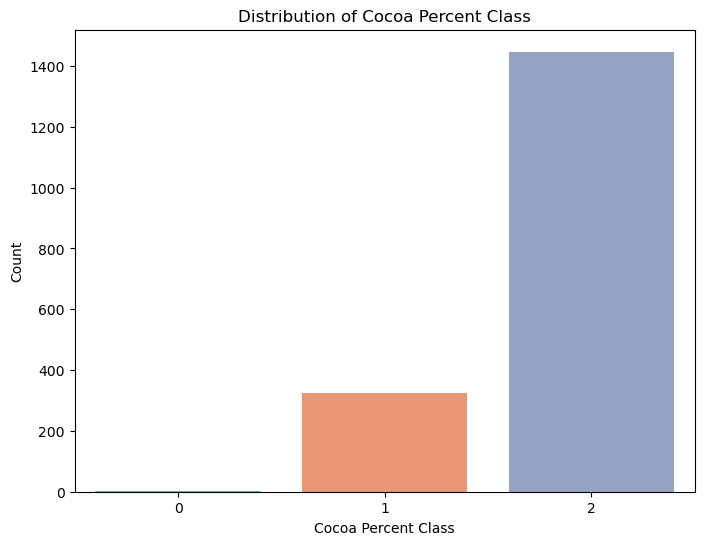

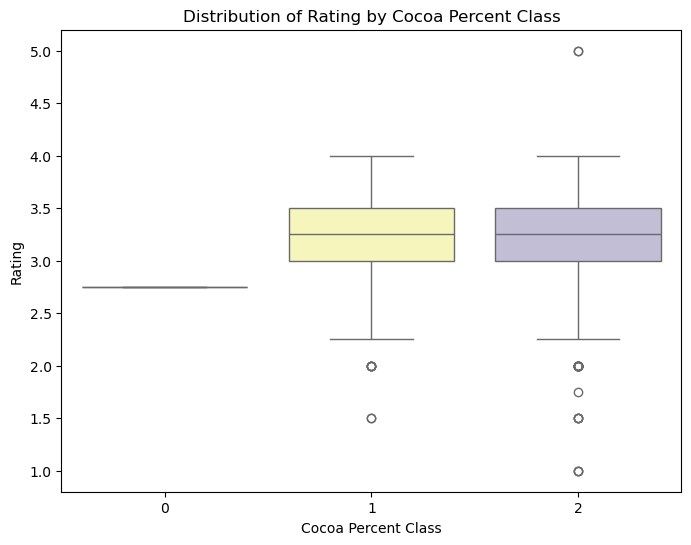

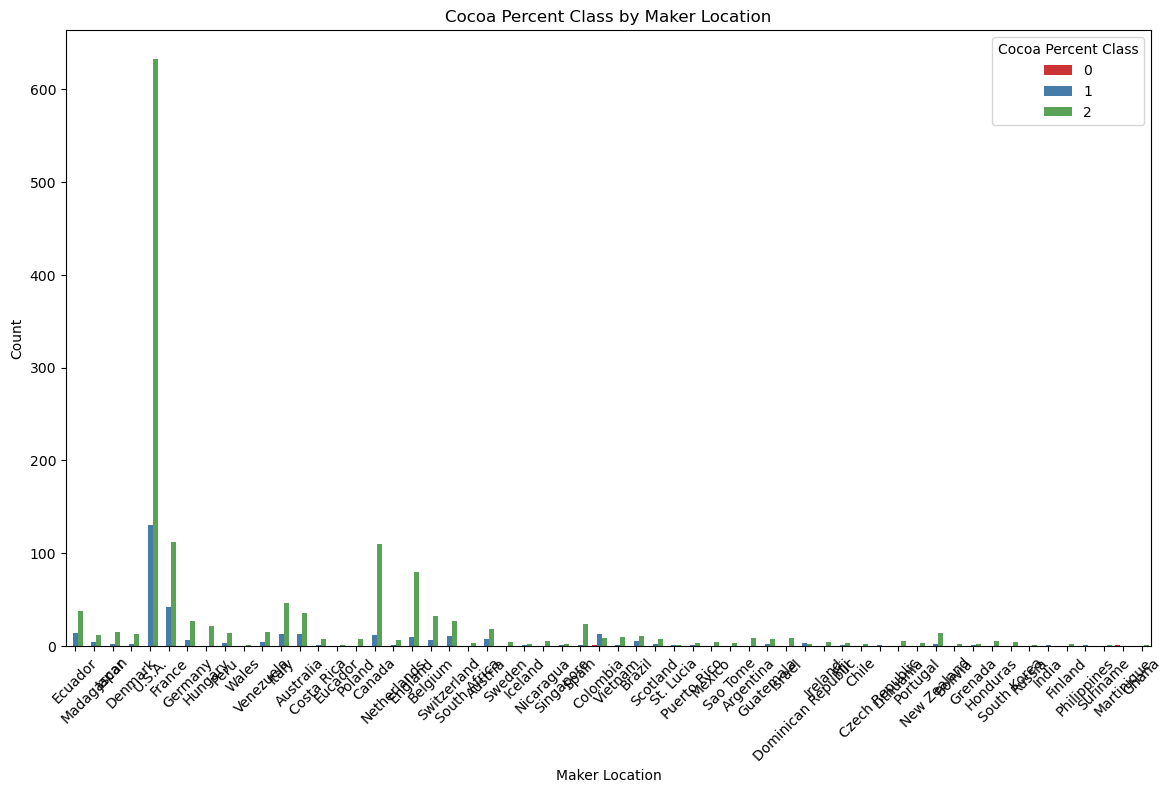

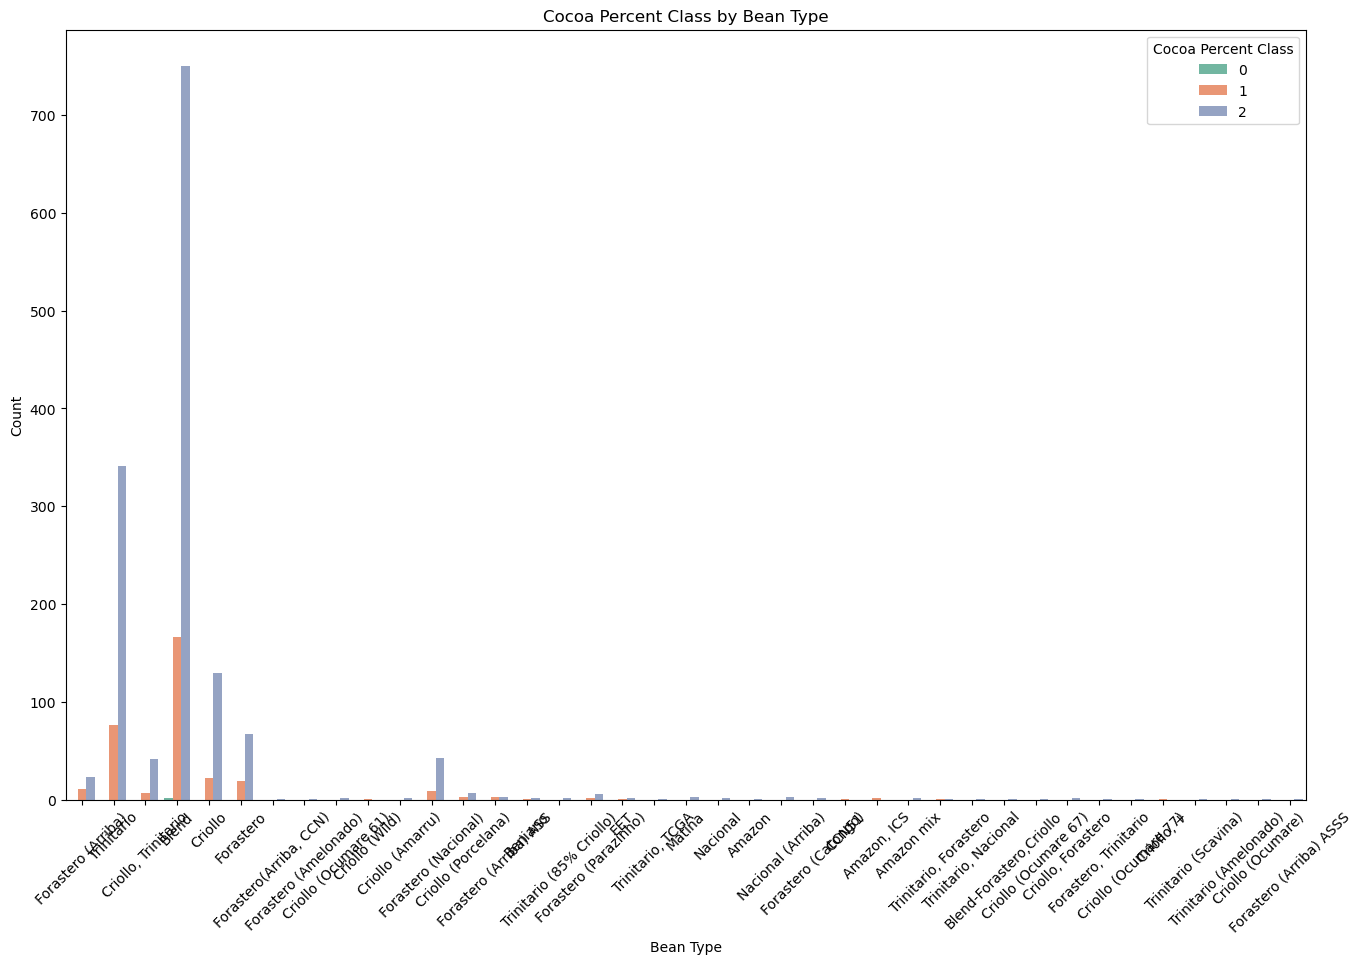

In [8]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: Distribution of cocoa_percent_class (Target Variable)
plt.figure(figsize=(8, 6))
sns.countplot(x='cocoa_percent_class', data=df_shuffled, palette='Set2')
plt.title('Distribution of Cocoa Percent Class')
plt.xlabel('Cocoa Percent Class')
plt.ylabel('Count')
plt.show()

# Plot 2: Distribution of Ratings by Cocoa Percent Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='cocoa_percent_class', y='rating', data=df_shuffled, palette='Set3')
plt.title('Distribution of Rating by Cocoa Percent Class')
plt.xlabel('Cocoa Percent Class')
plt.ylabel('Rating')
plt.show()

# Plot 3: Cocoa Percent Class vs Maker Location
plt.figure(figsize=(14, 8))
sns.countplot(x='maker_location', hue='cocoa_percent_class', data=df_shuffled, palette='Set1')
plt.title('Cocoa Percent Class by Maker Location')
plt.xlabel('Maker Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cocoa Percent Class', loc='upper right')
plt.show()

# Plot 4: Bean Type vs Cocoa Percent Class
plt.figure(figsize=(16, 10))
sns.countplot(x='bean_type', hue='cocoa_percent_class', data=df_shuffled, palette='Set2')
plt.title('Cocoa Percent Class by Bean Type')
plt.xlabel('Bean Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Cocoa Percent Class', loc='upper right')
plt.show()



Analysis:-

Figure 1: Overall the data sample of Chocolate Bar has higher Cocoa Percentage.

Figure 2: The Rating of Chocolate Bar with lower Cocoa percentage has been low.

Figure 3: Denmark made Chocolate Bar has highest percentage of Cocoa.

Figure 4: Chocolate which has bean type of Criollo and Trinitario has higher Cocoa percentage.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 5:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

1. Implement this baseline and report the accuracy metric on the train data;

2. Implement a function that computes the Log Loss (cross-entropy loss) metric and use it to evaluate this baseline on both the train and validation data. Note: reflect on what you know about the original distribution of classes in your training data (Hint: see Assignment 4 - Exercise 8 and ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example).

In [9]:
# YOUR CODE HERE

import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Define the custom cross-entropy loss function
def ce_loss(preds, Y, epsilon=1e-15):
    """
    preds are (m, n) where m = number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    """
    m = Y.shape[0]

    # Prevent log(0) by adding a small epsilon to predictions
    preds = np.clip(preds, epsilon, 1. - epsilon)

    # Convert sparse labels to one-hot encoding
    Y_dense = tf.keras.utils.to_categorical(Y, num_classes=preds.shape[1])

    # Compute the cross-entropy for each example
    cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

    # Compute the average cross-entropy loss
    loss = np.sum(cross_entropy_values) / m

    return loss

# Determine the Majority Class from the Training Data
majority_class = df_shuffled['cocoa_percent_class'].mode()[0]  # Find the most frequent class in the training data

# Create Baseline Predictions
# For simplicity, assume that our baseline prediction is the majority class for all instances in the dataset.
baseline_train_preds = np.full_like(y_train, majority_class)

# Remove rows with NaN values
y_train_cleaned = y_train.dropna()
y_val_cleaned = y_val.dropna()

# Create Baseline Predictions
# For simplicity, assume that our baseline prediction is the majority class for all instances in the dataset.
baseline_train_preds = np.full_like(y_train_cleaned, majority_class)
baseline_val_preds = np.full_like(y_val_cleaned, majority_class)
# Create the baseline predictions as probabilities for each class
num_classes = len(np.unique(y_train_cleaned))
val_num_classes = len(np.unique(y_val_cleaned))
baseline_train_preds_prob = np.zeros((y_train_cleaned.shape[0], num_classes))  # Shape (m, n)
baseline_val_preds_prod = np.zeros((y_val_cleaned.shape[0],num_classes)) 
baseline_train_preds_prob[:, majority_class] = 1  # Set the majority class probability to 1 for all examples
baseline_val_preds_prod[:, majority_class] = 1
# print(baseline_train_preds_prob.shape)
# print("__________________")
# print(y_train_cleaned.shape)

# Calculate Accuracy on the Training Data
baseline_train_accuracy = accuracy_score(y_train_cleaned, baseline_train_preds)
print(f"Accuracy of the Majority Class Baseline on Training Data: {baseline_train_accuracy:.4f}")

# Compute Log Loss on the Training Data
baseline_train_log_loss = ce_loss(baseline_train_preds_prob, y_train_cleaned)
print(f"Log Loss of the Majority Class Baseline on Training Data: {baseline_train_log_loss:.4f}")

# Compute Log Loss on the Validation Data
baseline_val_log_loss = ce_loss(baseline_val_preds_prod, y_val_cleaned)
print(f"Log Loss of the Majority Class Baseline on Validation Data: {baseline_val_log_loss:.4f}")

Accuracy of the Majority Class Baseline on Training Data: 0.8120
Log Loss of the Majority Class Baseline on Training Data: 6.4923
Log Loss of the Majority Class Baseline on Validation Data: 6.3853


### <span style="color:chocolate">Exercise 6:</span> Improvement over baseline with Tensorflow (10 points)

Use TensorFlow (TF) to train a multiclass logistic regression model much like you did in Assignment 4. The goal here is to build a ML model to improve over the baseline classifier. You have the flexibility to choose which features to include.

With this in mind, complete the following tasks:

1. Build and compile a multiclass classification TF model (call it model_tf). Hint: the activation function, the loss, and the evaluation metric are different compared to the binary logistic regression (see ``Module Demos/05 Multiclass Logistic Regression.ipynb`` in bCourses for an example). Set learning_rate = 0.0001 and optimizer = SGD.
2. Train model_tf using the training dataset and pass the validation data for validation. Set num_epochs = 10 and batch_size = 32.
3. Generate a plot (for the training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title.

If instructions for any other hyperparameters are not provided here, you are free to select your own or use the default settings.

Epoch 1/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7814 - loss: 0.5761 - val_accuracy: 0.8162 - val_loss: 0.4874
Epoch 2/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8227 - loss: 0.4630 - val_accuracy: 0.8134 - val_loss: 0.5261
Epoch 3/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.4685 - val_accuracy: 0.8189 - val_loss: 0.6091
Epoch 4/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8201 - loss: 0.4279 - val_accuracy: 0.7994 - val_loss: 0.5734
Epoch 5/5
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8146 - loss: 0.4300 - val_accuracy: 0.7939 - val_loss: 0.6650


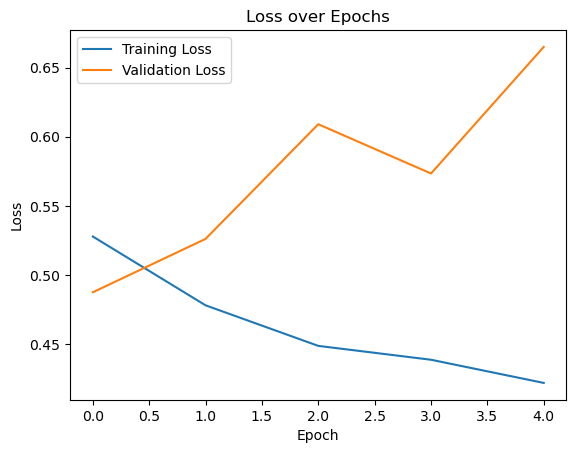

In [10]:
# YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure the data type is float32 for TensorFlow
X_train_encoded = X_train_encoded.astype('float32')
X_val_encoded = X_val_encoded.astype('float32')

# Convert y_train from categorical to integers
y_train_int = y_train.cat.codes  # Convert category type to integer codes
y_test_int = y_test.cat.codes
# One-hot encode the integer labels
y_train_encoded = tf.keras.utils.to_categorical(y_train_int, num_classes=3)
y_test_encoded = tf.keras.utils.to_categorical(y_test_int, num_classes=3)
# Convert y_val from categorical to integers
y_val_int = y_val.cat.codes  # Convert category type to integer codes

# One-hot encode the integer labels
y_val_encoded = tf.keras.utils.to_categorical(y_val_int, num_classes=3)

# Build and compile the model
model_tf = Sequential()

# Add the hidden layers (you can customize the number of layers and neurons)
model_tf.add(Dense(64, input_dim=X_train_encoded.shape[1], activation='relu'))  # First hidden layer
model_tf.add(Dense(64, activation='relu'))  # Second hidden layer

# Output layer: 3 units for 3 classes, activation 'softmax' for multiclass classification
model_tf.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_tf.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model_tf.fit(X_train_encoded, y_train_encoded, 
                       epochs=5, 
                       batch_size=5, 
                       validation_data=(X_val_encoded, y_val_encoded))

# Optionally, visualize the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


---
### Step 5: Hyperparameter tuning

### <span style="color:chocolate">Exercise 7:</span> Choosing hyperparameters (10 points)

1. Fine-tune the **learning rate**, **number of epochs**, and **batch size** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). 

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

Training with lr=0.001, epochs=5, batch_size=16
Final Train Loss: 0.4427, Validation Loss: 0.5046
Percentage Difference: -12.28%

Training with lr=0.001, epochs=5, batch_size=32
Final Train Loss: 0.4637, Validation Loss: 0.4888
Percentage Difference: -5.14%

Training with lr=0.001, epochs=5, batch_size=64
Final Train Loss: 0.4919, Validation Loss: 0.4972
Percentage Difference: -1.06%

Training with lr=0.001, epochs=10, batch_size=16
Final Train Loss: 0.3911, Validation Loss: 0.5526
Percentage Difference: -29.22%

Training with lr=0.001, epochs=10, batch_size=32
Final Train Loss: 0.4216, Validation Loss: 0.5151
Percentage Difference: -18.15%

Training with lr=0.001, epochs=10, batch_size=64
Final Train Loss: 0.4480, Validation Loss: 0.4947
Percentage Difference: -9.45%

Training with lr=0.001, epochs=15, batch_size=16
Final Train Loss: 0.3583, Validation Loss: 0.5899
Percentage Difference: -39.25%

Training with lr=0.001, epochs=15, batch_size=32
Final Train Loss: 0.3824, Validation Los

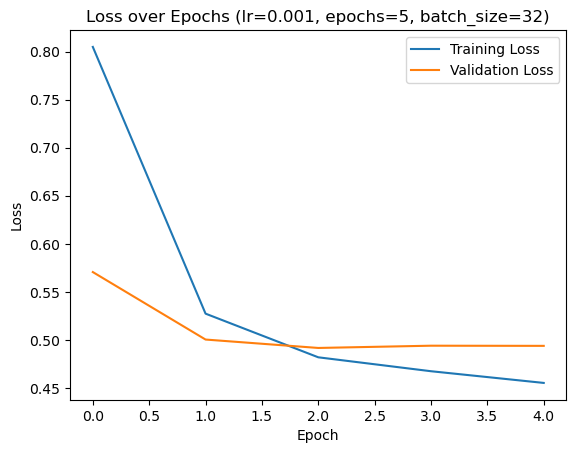

Baseline Model - Training Loss: 6.4923, Validation Loss: 6.3853
Best Model - Training Loss: 0.4637, Validation Loss: 0.4888


In [11]:
# YOUR CODE HERE
# Function to train the model with different hyperparameters and return results
def train_model(learning_rate, epochs, batch_size):
    # Build and compile the model
    model_tf = Sequential()
    model_tf.add(Dense(64, input_dim=X_train_encoded.shape[1], activation='relu'))  # Hidden layer 1
    model_tf.add(Dense(64, activation='relu'))  # Hidden layer 2
    model_tf.add(Dense(3, activation='softmax'))  # Output layer

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_tf.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model_tf.fit(X_train_encoded, y_train_encoded, 
                           epochs=epochs, 
                           batch_size=batch_size, 
                           validation_data=(X_val_encoded, y_val_encoded), 
                           verbose=0)

    return model_tf, history

# Function to calculate percentage difference between training and validation loss
def calc_loss_percentage_difference(history):
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    return ((train_loss - val_loss) / val_loss) * 100

# Hyperparameters to test
learning_rates = [0.001, 0.01, 0.1]
epochs_list = [5, 10, 15]
batch_sizes = [16, 32, 64]

# Store results
results = []

# Iterate over the different hyperparameter values
for learning_rate in learning_rates:
    for epochs in epochs_list:
        for batch_size in batch_sizes:
            print(f"Training with lr={learning_rate}, epochs={epochs}, batch_size={batch_size}")
            model, history = train_model(learning_rate, epochs, batch_size)
            
            # Get final training and validation loss
            train_loss = history.history['loss'][-1]
            val_loss = history.history['val_loss'][-1]
            loss_diff_percentage = calc_loss_percentage_difference(history)
            
            results.append({
                'learning_rate': learning_rate,
                'epochs': epochs,
                'batch_size': batch_size,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'loss_diff_percentage': loss_diff_percentage
            })
            
            # Print out the results
            print(f"Final Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
            print(f"Percentage Difference: {loss_diff_percentage:.2f}%\n")

# Identify the best performing model based on the lowest validation loss
best_model = min(results, key=lambda x: x['val_loss'])
print("Best Model Configuration:")
print(best_model)

# After fine-tuning the model, let's access the first 5 learned parameters:
model_tf, _ = train_model(best_model['learning_rate'], best_model['epochs'], best_model['batch_size'])

# Get the weights and biases of the first layer
weights, biases = model_tf.layers[0].get_weights()

# Print the first 5 learned parameters (weights and biases)
print("First 5 learned parameters (weights and biases):")
print("Weights (first 5 values):", weights.flatten()[:5])
print("Biases (first 5 values):", biases[:5])

# Optionally, visualize the training and validation loss for the best model
history = model_tf.history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f"Loss over Epochs (lr={best_model['learning_rate']}, epochs={best_model['epochs']}, batch_size={best_model['batch_size']})")
plt.legend()
plt.show()

# Now compare the TensorFlow model's loss with the baseline model's loss
baseline_train_loss = 6.4923  
baseline_val_loss = 6.3853

print(f"Baseline Model - Training Loss: {baseline_train_loss:.4f}, Validation Loss: {baseline_val_loss:.4f}")

# Compare losses
print(f"Best Model - Training Loss: {best_model['train_loss']:.4f}, Validation Loss: {best_model['val_loss']:.4f}")

---
### Step 6: Evaluation and generalization

### <span style="color:chocolate">Exercise 8:</span> Compute metrics (10 points)

Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

1. Calculate aggregate accuracy on both train and test datasets. Note: you will need to convert the vector of predicted probabilities to a class label using the argmax operation. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method provided by tf.keras. and the <span style="color:chocolate">np.max()</span> method available in NumPy.

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [12]:
# YOUR CODE HERE
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate aggregate accuracy on the training dataset
train_predictions = model_tf.predict(X_train_encoded)  # Predict probabilities for training data
train_pred_labels = np.argmax(train_predictions, axis=1)  # Convert probabilities to class labels

# Calculate accuracy for training set
train_accuracy = accuracy_score(np.argmax(y_train_encoded, axis=1), train_pred_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate aggregate accuracy on the test dataset
test_predictions = model_tf.predict(X_test_encoded)  # Predict probabilities for test data
test_pred_labels = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels

# Calculate accuracy for test set
test_accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), test_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training Accuracy: 0.8143
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.8273


Analysis: The model demonstrates similar performance on both training and test sets since the accuracy values are 0.8143 and 0.8273 respectively.

### <span style="color:chocolate">Exercise 9:</span> Additional metrics (10 points)

Using the test dataset:

1. Plot the confusion matrix. Identify which class the model confuses the most.

2. Determine which class has the lowest precision. What is the precision? Which class is the largest source of false positives?

3. Determine which class has the lowest recall. What is the recall? Which class is the largest source of false negatives?

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


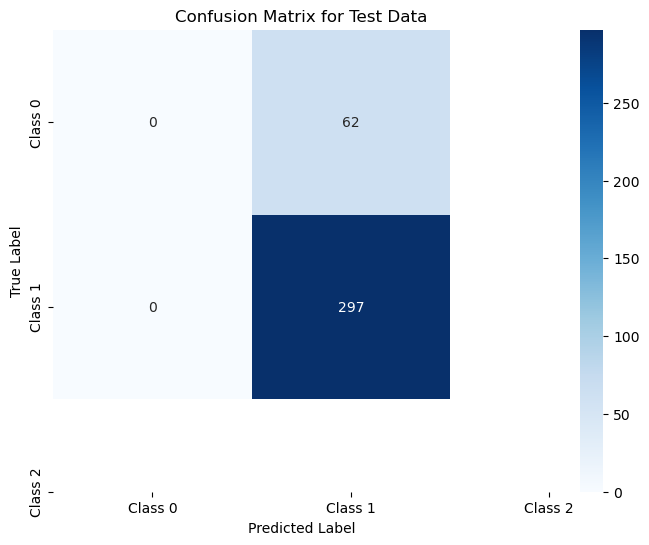

Precision for each class: [0.         0.82729805]
Class with the lowest precision: Class 0 with precision 0.0000
Recall for each class: [0. 1.]
Class with the lowest recall: Class 0 with recall 0.0000
Largest source of false positives: Class 1 with 62 false positives
Largest source of false negatives: Class 0 with 62 false negatives


In [13]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Generate the predictions
test_predictions = model_tf.predict(X_test_encoded)  # Get predicted probabilities
test_pred_labels = np.argmax(test_predictions, axis=1)  # Convert to predicted class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_encoded, axis=1), test_pred_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate Precision and Recall for each class
precision = precision_score(np.argmax(y_test_encoded, axis=1), test_pred_labels, average=None)
recall = recall_score(np.argmax(y_test_encoded, axis=1), test_pred_labels, average=None)

# Identify the class with the lowest precision
min_precision_class = np.argmin(precision)
min_precision_value = precision[min_precision_class]

# Identify the class with the lowest recall
min_recall_class = np.argmin(recall)
min_recall_value = recall[min_recall_class]

# Step 4: Output the results
print(f"Precision for each class: {precision}")
print(f"Class with the lowest precision: Class {min_precision_class} with precision {min_precision_value:.4f}")

print(f"Recall for each class: {recall}")
print(f"Class with the lowest recall: Class {min_recall_class} with recall {min_recall_value:.4f}")

# Step 5: Identify sources of false positives and false negatives
false_positives = conf_matrix.sum(axis=0) - np.diagonal(conf_matrix)
false_negatives = conf_matrix.sum(axis=1) - np.diagonal(conf_matrix)

# Largest source of false positives
largest_fp_class = np.argmax(false_positives)
largest_fp_value = false_positives[largest_fp_class]

# Largest source of false negatives
largest_fn_class = np.argmax(false_negatives)
largest_fn_value = false_negatives[largest_fn_class]

print(f"Largest source of false positives: Class {largest_fp_class} with {largest_fp_value} false positives")
print(f"Largest source of false negatives: Class {largest_fn_class} with {largest_fn_value} false negatives")

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Following the approach in Assignment 4 - Exercise 12, evaluate whether your model shows any signs of unfairness. Explain your findings and propose suggestions for improvement.

In [14]:
# YOUR CODE HERE